In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
transform = transforms.ToTensor()

train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False, download=True, transform=transform)

In [ ]:
def num_correct(output, target):

  _ , pred = torch.max(output, dim = 1)

  return torch.sum(pred == target).item()

In [ ]:
def train(model, batch, crit, optim, train_data):

  train_loader = DataLoader(train_data, batch_size=batch, shuffle=True)

  for _ , (images, targets) in enumerate(train_loader):
    optim.zero_grad()
    output = model(images)
    loss = crit(output, targets)
    loss.backward()
    optim.step()


In [ ]:
def findParamValue(param_name, model):

  targ_val = None

  for name, param in model.named_parameters():
    if name == param_name:
      targ_val = param.data.numpy()

  return targ_val

In [ ]:
def changeParams(alpha, mainMod, model1, model2):
  for name, param in mainMod.named_parameters():

    val1 = findParamValue(name, model1)
    val2 = findParamValue(name, model2)

    param.data = torch.tensor(alpha*val1 + (1-alpha)*val2)



In [ ]:
def train_int(model, crit, train_data):

  loss = 0.0
  correct = 0

  train_loader = DataLoader(train_data, batch_size=10000, shuffle=True)

  for _ , (images, targets) in enumerate(train_loader):

    output = model(images)
    loss = crit(output, targets).item()
    correct += num_correct(output,targets)

  accuracy = correct/len(train_data)

  return loss, accuracy



In [ ]:
def test_int(model, crit, test_data):

  loss = 0.0
  correct = 0

  test_loader = DataLoader(test_data, batch_size=10000, shuffle=True)

  for _ , (images, targets) in enumerate(test_loader):

    output = model(images)
    loss = crit(output, targets).item()
    correct = num_correct(output,targets)

  accuracy = correct/len(test_data)

  return loss, accuracy

In [ ]:
class Model(nn.Module):

  def __init__(self, hid_nodes=256):
    super().__init__()
    self.fc1 = nn.Linear(784, hid_nodes)
    self.fc2 = nn.Linear(hid_nodes, hid_nodes)
    self.output = nn.Linear(hid_nodes, 10)

  def forward(self, x):
    x = x.view(-1, 28*28)
    x = F.tanh(self.fc1(x))
    x = F.tanh(self.fc2(x))
    x = self.output(x)
    return F.log_softmax(x, dim=1)

In [ ]:
model1 = Model()
model2 = Model()
model_int = Model()

crit1 = nn.CrossEntropyLoss()
crit2 = nn.CrossEntropyLoss()
crit_int = nn.CrossEntropyLoss()

optim1 = optim.Adam(model1.parameters(), lr=0.001)
optim2 = optim.Adam(model2.parameters(), lr=0.001)

alphas = np.linspace(-1, 2, 10)

In [ ]:
train(model1, 60, crit1, optim1, train_data)
train(model2, 1000, crit2, optim2, train_data)
train_loss_list = []
test_loss_list = []
train_acc_list = []
test_acc_list = []

for alpha in alphas:

  changeParams(alpha, model_int, model1, model2)
  loss, acc = train_int(model_int, crit_int, train_data)
  train_loss_list.append(loss)
  train_acc_list.append(acc)

  loss, acc = test_int(model_int, crit_int, test_data)
  test_loss_list.append(loss)
  test_acc_list.append(acc)

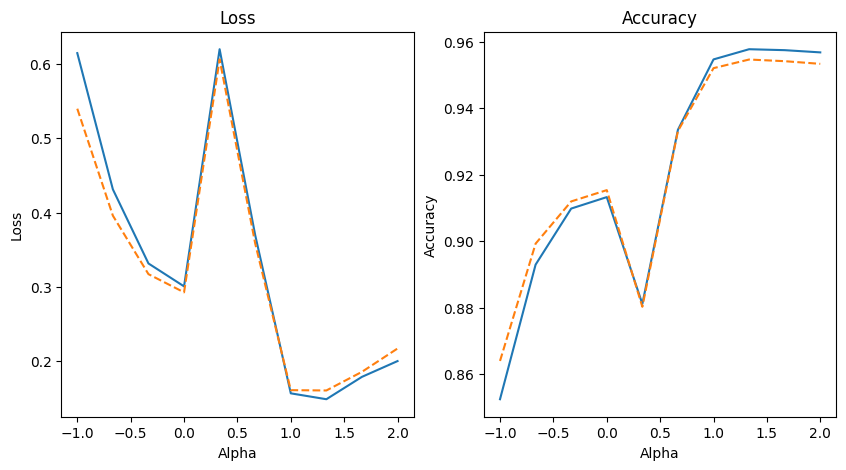

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(alphas, train_loss_list)
ax1.plot(alphas, test_loss_list, linestyle='--')
ax1.set_title('Loss')
ax1.set_xlabel('Alpha')
ax1.set_ylabel('Loss')

ax2.plot(alphas, train_acc_list)
ax2.plot(alphas, test_acc_list, linestyle='--')
ax2.set_title('Accuracy')
ax2.set_xlabel('Alpha')
ax2.set_ylabel('Accuracy')

plt.show()